In [14]:
import os
changed_dir = False
if not changed_dir:
    os.chdir("..")
    changed_dir=True

In [15]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("/home/piotr/Documents/mgr/uwb-rs/data-processing/data/movement/2023-05-24-13:52:11.266488_P3-1-6-5_normalized_high_up.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index(df.timestamp)
df

,Unnamed: 0,anchor,distance,instant,timestamp,acc_x,acc_y,acc_z
timestamp,,,,,,,,
2023-05-24 13:52:11.391647,0,0x6c0d,3331.0337,755152406981,2023-05-24 13:52:11.391647,1.075,0.007,-0.010
2023-05-24 13:52:11.520664,1,0x5601,3773.9844,763424874778,2023-05-24 13:52:11.520664,1.068,0.028,-0.037
2023-05-24 13:52:11.651807,2,0x26bd,2675.7068,771711288996,2023-05-24 13:52:11.651807,1.066,-0.003,-0.020
2023-05-24 13:52:11.786708,3,0x6c0d,3274.3574,780022644491,2023-05-24 13:52:11.786708,1.046,0.005,-0.057
2023-05-24 13:52:11.914416,4,0x5601,3788.0164,788331527342,2023-05-24 13:52:11.914416,1.054,0.019,-0.052
...,...,...,...,...,...,...,...,...
2023-05-24 13:52:49.786378,296,0x26bd,5690.4480,1009312570980,2023-05-24 13:52:49.786378,1.051,-0.023,-0.004
2023-05-24 13:52:49.917037,297,0x6c0d,2382.0566,1017606340111,2023-05-24 13:52:49.917037,1.057,-0.023,-0.002
2023-05-24 13:52:50.046483,298,0x5601,3234.6758,1025886936921,2023-05-24 13:52:50.046483,1.057,-0.029,-0.006


In [16]:
# Calibration
# stat_df = pd.read_csv("/home/piotr/Documents/mgr/uwb-rs/data-processing/2023-05-23-11:33:46.497651stationary.csv")
gravity = df[["acc_x", "acc_y", "acc_z"]].head(10).mean()


In [17]:
# Lowpass filter
import matplotlib.pyplot as plt
from scipy import signal, fft

# t = df.timestamp.diff().mean()
# fs = 1 / (t.to_pytimedelta().microseconds/10**6)
# fn = fs/2

# f_filter = 20.0
# f_filter_n = f_filter / fn


In [18]:

freq = fft.fft(df["acc_x"].to_numpy())

def low_pass(x, Wn: float = 0.3):
    # b, a = signal.butter(4, Wn, btype="lowpass")
    b, a = signal.iirfilter(4, Wn, btype="lowpass")
    s = signal.lfilter(b,a,x)
    plt.plot(s)
    plt.plot(x.reset_index(drop=True))
    return s


# # df["acc_y"] = df["acc_y"].to_frame().apply(low_pass)
# df[["acc_x", "acc_y", "acc_z"]] = (df[["acc_x", "acc_y", "acc_z"]] - gravity).apply(low_pass)
df[["acc_x", "acc_y", "acc_z"]] = df[["acc_x", "acc_y", "acc_z"]] - gravity
df[["acc_x", "acc_y", "acc_z"]] *= 9.80655 # Convert to m\s^2

<Axes: xlabel='timestamp'>

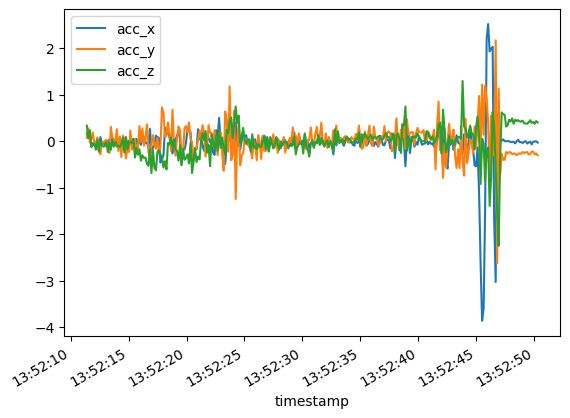

In [19]:
df[["acc_x","acc_y", "acc_z"]].plot.line()

In [20]:
# df[["velocity_x","velocity_y", "velocity_z"]] = df[["acc_x", "acc_y","acc_z"]].diff().rolling(window=1).mean().cumsum()
from scipy import integrate
import numpy as np

dv = df[["acc_x", "acc_y", "acc_z"]].expanding().apply(lambda g: integrate.trapezoid(g, g.index.astype(np.int64) / 10**9))
# dv = df[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()

px.line(dv, title="Velocity")
# df[["pos_x","pos_y", "pos_z"]] = df[["velocity_x","velocity_y", "velocity_z"]].cumsum()

In [21]:
dpos = dv[["acc_x", "acc_y", "acc_z"]].expanding().apply(lambda g: integrate.trapezoid(g, g.index.astype(np.int64) / 10**9))
# dpos = dv[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()
df[["pos_x", "pos_y", "pos_z"]] = dv[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()
px.line(dpos, title="Position")

In [22]:
import plotly.express as px

# px.line(df, x="timestamp", y="vector")

In [23]:

# px.line(df, x="timestamp", y=["velocity_x", "velocity_y", "velocity_z"])

In [24]:
px.line(df, x="timestamp", y=["pos_y", "pos_z"])

In [25]:
px.line(df, x="pos_y", y="pos_z")
# px.line_3d(df, x="pos_x", y="pos_y",z="pos_z")

In [26]:
px.scatter(df, x="pos_y", y="pos_z", animation_frame="timestamp",
            range_x=[df["pos_y"].min(), df["pos_y"].max()],
            range_y=[df["pos_z"].min(), df["pos_z"].max()]
            )